In [1]:
#   compare two worlds with cca


# note - look into unit circle normalization assumption more deeply




In [16]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import seaborn as sns

plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

import pymysql
import pickle
import json

import numpy as np
from sklearn.decomposition import PCA
import networkx as nx

import hdbscan
import umap

import time
import random
import re

import spacy
from gensim.models import Word2Vec

from pmids2vec import pmids2vec
from pmids2corpus import pmids2corpus

from sklearn.cross_decomposition import CCA
import scipy as sp


In [2]:
### load in 2 word2vec models trained on a coarse cluster

In [3]:
# temp, recreate the list of file names without re-training the w2v models

#model_names = ['data_processing/cluster0.model',
#        'data_processing/cluster1.model',
#        'data_processing/cluster2.model']


### pick just 2 models
model_names = ['data_processing/cluster1.model',
        'data_processing/cluster2.model']

short_names = []

print(model_names)
print()

models = {}

for model_name in model_names:
    
    short_name = str.split(model_name,'/')[-1]
    short_names.append(short_name)
    print(short_name)
    
    model = Word2Vec.load(model_name)
    models[short_name] = model
    print('{} words '.format(len(model.wv.vocab)))  # length of the vocab dict
    print()
    
    
#  ~16,000 words across all 3 clusters (> 25 times)
#  ~3,000 words occurring in all 3 clusters (> 25 times)
#  window size 15

['data_processing/cluster1.model', 'data_processing/cluster2.model']

cluster1.model
5275 words 

cluster2.model
10261 words 



### get shared vocabulary

In [4]:
shared_vocabulary = {}

for i_model, model_name in enumerate(model_names):    
    short_name = str.split(model_name,'/')[-1]
    
    this_vocab = set(models[short_name].wv.vocab)
    
    if i_model==0:
        shared_vocabulary = this_vocab
    elif i_model==1:
        shared_vocabulary = shared_vocabulary.intersection(this_vocab)
        shared_vocabulary = list(shared_vocabulary)
        
print("size of shared vocabulary: {}".format(len(shared_vocabulary)))

size of shared vocabulary: 3520


### build embedding sample matrices

In [5]:
samples = {}
for model_name in model_names:
    
    short_name = str.split(model_name,'/')[-1]
    print(short_name)
    
    D = np.shape(models[short_name].wv['data'])[0] # dimensionality of a sample word, any word will do
    print("number of dimensions D: {}".format(D))
    
    embedding_samples = np.zeros( (len(shared_vocabulary), D) )
    
    # collect samples  (just take every point since these aren't too big)
    for i_word, word in enumerate(shared_vocabulary):
        embedding_samples[i_word,:] = models[short_name].wv[word]
        
    # demean
    '''
    for i_word, word in enumerate(shared_vocabulary):
        embedding_samples[i_word,:] -= np.mean(embedding_samples,0)
    
    # normalize all vectors to the hypersphere
    for i_row,row in enumerate(embedding_samples):
        embedding_samples[i_row,:] /= np.linalg.norm(row,2)
    '''
    
    samples[short_name] = embedding_samples

cluster1.model
number of dimensions D: 25
cluster2.model
number of dimensions D: 25


In [6]:
### visualize before alignment

(3520, 25)
(3520, 25)


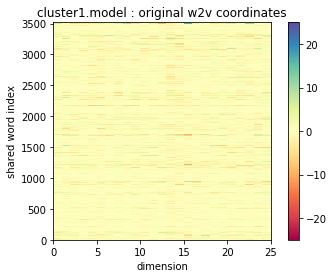

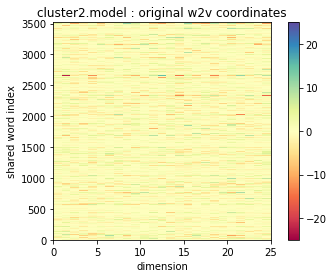

In [7]:

for sample_name,sample_matrix in samples.items():
    
    print(np.shape(sample_matrix))
        
    plt.figure()
    plt.imshow(sample_matrix,
               origin='lower',
               extent=[0,D,0,len(shared_vocabulary)],
               aspect= D / len(shared_vocabulary),
               vmin = -25,
               vmax = 25,
               cmap='Spectral')
    plt.colorbar()
    plt.title('{} : original w2v coordinates'.format(sample_name))
    
    plt.xlabel('dimension')
    plt.ylabel('shared word index')
    
    #plt.savefig('figures_2/w2v original coords {}.png'.format(sample_name[:8]))
    #plt.savefig('figures_2/w2v original coords {}.pdf'.format(sample_name[:8]))


In [8]:
### use cca to align the two spaces

(3520, 25)
(25, 25)
(3520, 3)
(3520, 3)
(3,)


Text(0.5, 0, 'canonical component')

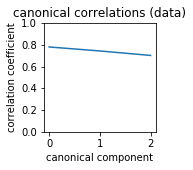

In [12]:
N_components = 3

U = samples[short_names[0]]
V = samples[short_names[1]]
print(np.shape(U))

cca = CCA(n_components=N_components)
cca.fit(U, V)

print(cca.coef_.shape)                   # (5,5)

U_c, V_c = cca.transform(U, V)

print(U_c.shape)                         # (100,1)
print(V_c.shape)                         # (100,1)

# distribution of canonical correlations
cc_corr = np.corrcoef(cca.x_scores_,
                      cca.y_scores_,
                      rowvar=False).diagonal(offset=cca.n_components)
print(np.shape(cc_corr))

plt.figure(figsize=(2,2))
plt.plot(cc_corr)
plt.ylim([0,1])
plt.title('canonical correlations (data)')
plt.ylabel('correlation coefficient')
plt.xlabel('canonical component')

#plt.savefig('figures_2/canonical correlations (data).png')
#plt.savefig('figures_2/canonical correlations (data).pdf')

In [10]:
### visualize the spaces after alignment

(3520, 3)


Text(0, 0.5, 'shared word index')

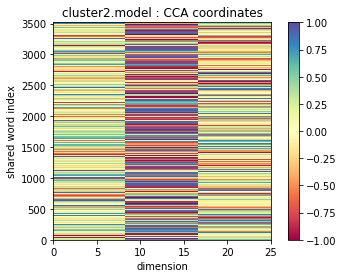

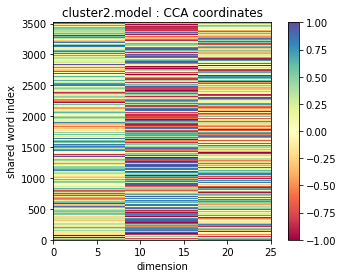

In [13]:
print(np.shape(U_c))

doNorm = True
if doNorm:
    for i_row, row in enumerate(U_c):
        U_c[i_row,:] = row / np.linalg.norm(row)
    for i_row, row in enumerate(V_c):
        V_c[i_row,:] = row / np.linalg.norm(row)


plt.figure()
plt.imshow(U_c,
           origin='lower',
           extent=[0,D,0,len(shared_vocabulary)],
           aspect= D / len(shared_vocabulary),
           vmin = -1,
           vmax = 1,
           cmap='Spectral')     
plt.colorbar()
plt.title('{} : CCA coordinates'.format(sample_name))
plt.xlabel('dimension')
plt.ylabel('shared word index')

#plt.savefig('figures_2/w2v CCA coords {}.png'.format(1))
#plt.savefig('figures_2/w2v CCA coords {}.svg'.format(1))

plt.figure()
plt.imshow(V_c,
           origin='lower',
           extent=[0,D,0,len(shared_vocabulary)],
           aspect= D / len(shared_vocabulary),
           vmin = -1,
           vmax = 1,
           cmap='Spectral')     
plt.colorbar()
plt.title('{} : CCA coordinates'.format(sample_name))
plt.xlabel('dimension')
plt.ylabel('shared word index')

#plt.savefig('figures_2/w2v CCA coords {}.png'.format(2))
#plt.savefig('figures_2/w2v CCA coords {}.pdf'.format(2))



In [13]:
### find most similar and most dissimilar words

most similar
[('_number_', 100), ('facilitates', 210), ('pathogenesis', 262), ('current', 280), ('forward', 332), ('contribution', 355), ('confirmed', 478), ('shown', 500), ('could', 516), ('can', 582), ('correlation', 672), ('why', 768), ('five', 804), ('same', 823), ('mesenteric', 829), ('human', 852), ('forming', 870), ('plays', 918), ('contributed', 994), ('eight', 1001), ('affects', 1121), ('have', 1132), ('urgently', 1230), ('reproductive', 1274), ('syndrome', 1318), ('counts', 1381), ('towards', 1411), ('removed', 1432), ('contributions', 1518), ('triggers', 1600), ('male', 1800), ('critical', 1810), ('onset', 1814), ('fbs', 1843), ('it', 1864), ('does', 1871), ('radiotherapy', 1944), ('immunotherapy', 1963), ('than', 1969), ('identifies', 2003), ('were', 2067), ('cdc', 2085), ('investigated', 2090), ('studied', 2119), ('idiopathic', 2155), ('organ', 2160), ('dietary', 2244), ('overview', 2329), ('may', 2561), ('challenges', 2567), ('that', 2593), ('might', 2599), ('less', 2604)

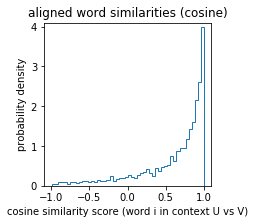

In [14]:
similarities = []
for i_word, word in enumerate(shared_vocabulary):
    
    # check norms (why does CCA not produce unit vectors)
    #print(np.linalg.norm(U_c[i_word]))  #  4.7
    #print(np.linalg.norm(V_c[i_word]))  #  5.4
    
    score = 1 - sp.spatial.distance.cosine(U_c[i_word], V_c[i_word])
    similarities.append(score)    

plt.figure(figsize=(3,3))
plt.hist(similarities, histtype='step', bins=50, density=True)
plt.title('aligned word similarities (cosine)')
plt.ylim([0,4.1])

plt.xlabel('cosine similarity score (word i in context U vs V)')
plt.ylabel('probability density')

plt.savefig('figures_2/aligned word similarities.png')
plt.savefig('figures_2/aligned word similarities.pdf')


high_cutoff = np.percentile(similarities, 98)
low_cutoff = np.percentile(similarities, 2)

most_similar_words = []
least_similar_words = []
for i_word, word in enumerate(shared_vocabulary):
    if similarities[i_word] >= high_cutoff:
        most_similar_words.append( (word, i_word) )
    
    elif similarities[i_word] <= low_cutoff:
        least_similar_words.append( (word, i_word) )
        
print('most similar')
print(most_similar_words)
print()
print('least similar')
print(least_similar_words)

# todo distinguish based on direction of difference

# todo compare shuffled similarities  (check - this can be found in check_null_CCA.ipynb)

## merge the two clusters and compare with umap

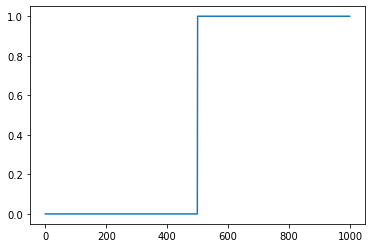

In [19]:
k_truncate = 500
world_1 = samples[short_names[0]][:k_truncate]
world_2 = samples[short_names[1]][:k_truncate]
merged_worlds = np.vstack((world_1, world_2))

world_labels = np.zeros( (1,len(merged_worlds)))
world_labels = world_labels.flatten()
world_labels[len(world_1):] = 1
plt.plot(world_labels)

reducer = umap.UMAP(output_metric='hyperboloid',
                    n_components=2,
                    metric='cosine')
um = reducer.fit_transform(merged_worlds)

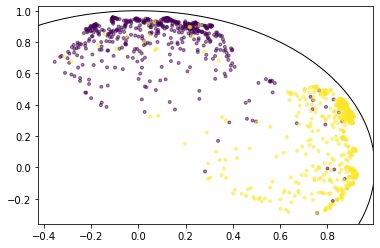

In [20]:
z = np.sqrt(1 + np.sum(reducer.embedding_**2, axis=1))  # map to the poincare disk
disk_x = um[:,0] / (1 + z)
disk_y = um[:,1] / (1 + z)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(disk_x, disk_y,
           c=world_labels, cmap='viridis',
           marker='.',
           alpha=0.5)
boundary = plt.Circle((0,0), 1, fc='none', ec='k')
ax.add_artist(boundary)
ax.axis('on');



## experiment with visualizing cc's more directly

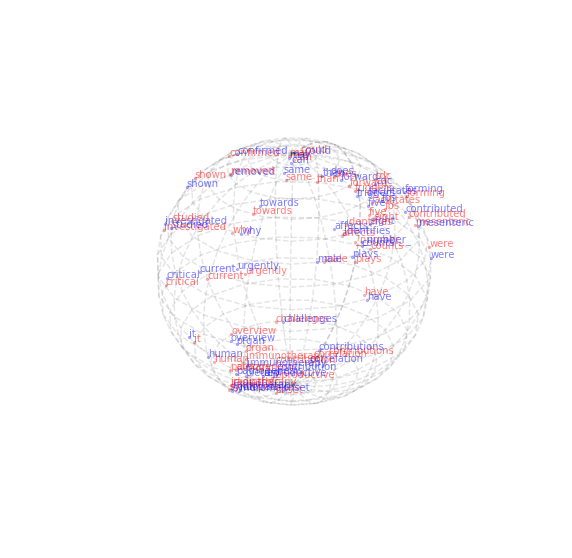

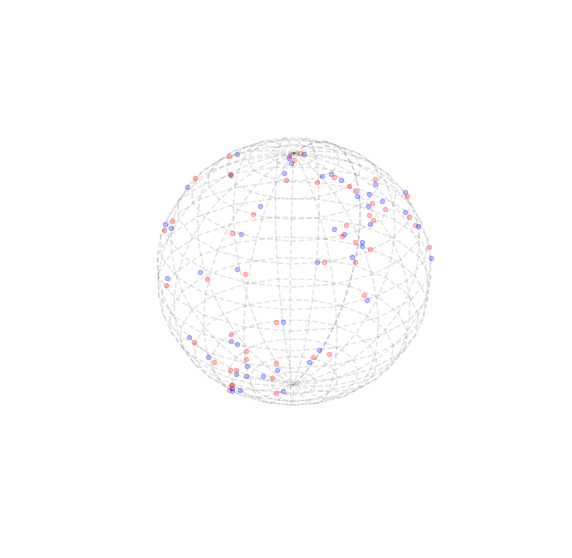

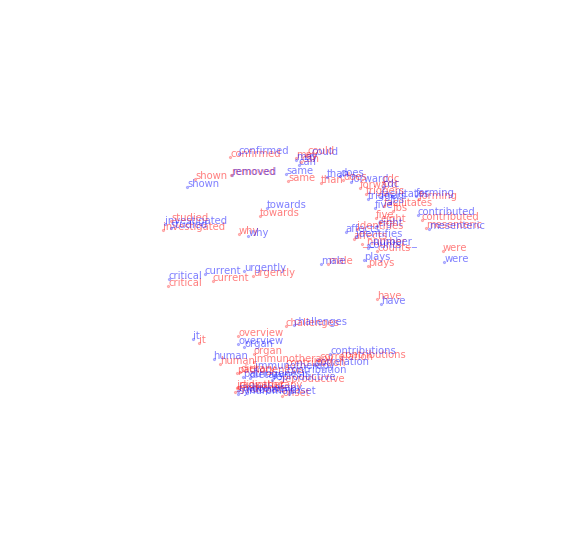

In [40]:

sample_idxs = [pair[1] for pair in most_similar_words[:50]]

##############################################################

marker_ = '.'
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

u = np.linspace(0, np.pi, 20)
v = np.linspace(0, 2 * np.pi, 20)

x = np.outer(np.sin(u), np.sin(v))
y = np.outer(np.sin(u), np.cos(v))
z = np.outer(np.cos(u), np.ones_like(v))

ax.plot_wireframe(x, y, z,
                color='k',
                linestyle='--',
                alpha=0.1)



dim1 = 0
dim2 = 1
dim3 = 2
for i,v in enumerate(sample_idxs):

        
    ax.scatter(U_c[v, dim1], U_c[v, dim2], U_c[v, dim3],
                color='r', marker=marker_,
                alpha=0.25)
    ax.text(U_c[v, dim1], U_c[v, dim2], U_c[v, dim3],
             s=shared_vocabulary[v],
             color='r',alpha=0.5)

    ax.scatter(V_c[v, dim1], V_c[v, dim2], V_c[v, dim3],
                color='b', marker=marker_,
                alpha=0.25)
    ax.text(V_c[v, dim1], V_c[v, dim2], V_c[v, dim3],
             s=shared_vocabulary[v],
             color='b',alpha=0.5)


ax.axis('off')

plt.savefig('figures_2/sphere similar words for worlds 1 2.png',
            transparent=True,
            bbox_inches='tight')
plt.savefig('figures_2/sphere similar words for worlds 1 2.pdf',
            transparent=True,
            bbox_inches='tight')


#####################################################

marker_ = 'o'
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

u = np.linspace(0, np.pi, 20)
v = np.linspace(0, 2 * np.pi, 20)

x = np.outer(np.sin(u), np.sin(v))
y = np.outer(np.sin(u), np.cos(v))
z = np.outer(np.cos(u), np.ones_like(v))

ax.plot_wireframe(x, y, z,
                color='k',
                linestyle='--',
                alpha=0.1)
dim1 = 0
dim2 = 1
dim3 = 2
for i,v in enumerate(sample_idxs):
        
    ax.scatter(U_c[v, dim1], U_c[v, dim2], U_c[v, dim3],
                color='r', marker=marker_,
                alpha=0.25)

    ax.scatter(V_c[v, dim1], V_c[v, dim2], V_c[v, dim3],
                color='b', marker=marker_,
                alpha=0.25)

ax.axis('off')

plt.savefig('figures_2/sphere similar words for worlds 1 2_points only.png',
            transparent=True,
            bbox_inches='tight')
plt.savefig('figures_2/sphere similar words for worlds 1 2_points only.pdf',
            transparent=True,
            bbox_inches='tight')

######################################################

marker_ = '.'
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

dim1 = 0
dim2 = 1
dim3 = 2
for i,v in enumerate(sample_idxs):
        
        
    ax.scatter(U_c[v, dim1], U_c[v, dim2], U_c[v, dim3],
                color='r', marker=marker_,
                alpha=0.25)
    ax.text(U_c[v, dim1], U_c[v, dim2], U_c[v, dim3],
             s=shared_vocabulary[v],
             color='r',alpha=0.5)

    ax.scatter(V_c[v, dim1], V_c[v, dim2], V_c[v, dim3],
                color='b', marker=marker_,
                alpha=0.25)
    ax.text(V_c[v, dim1], V_c[v, dim2], V_c[v, dim3],
             s=shared_vocabulary[v],
             color='b',alpha=0.5)
ax.axis('off')

plt.savefig('figures_2/sphere similar words for worlds 1 2_text only.png',
            transparent=True,
            bbox_inches='tight')
plt.savefig('figures_2/sphere similar words for worlds 1 2_text only.pdf',
            transparent=True,
            bbox_inches='tight')


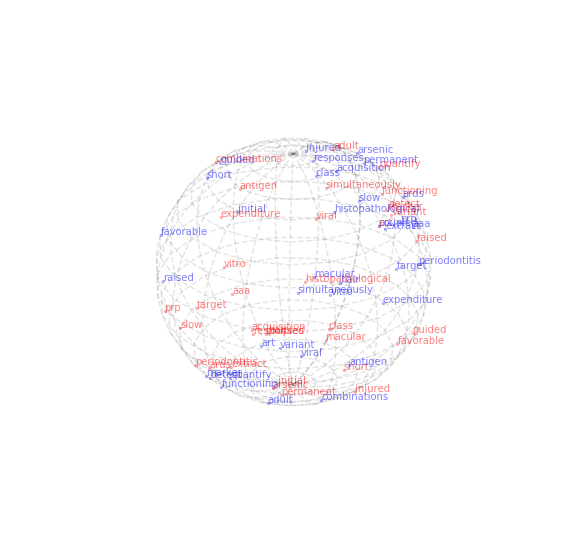

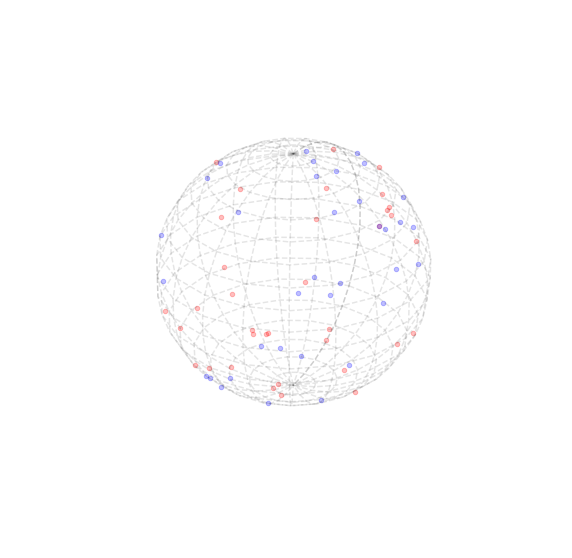

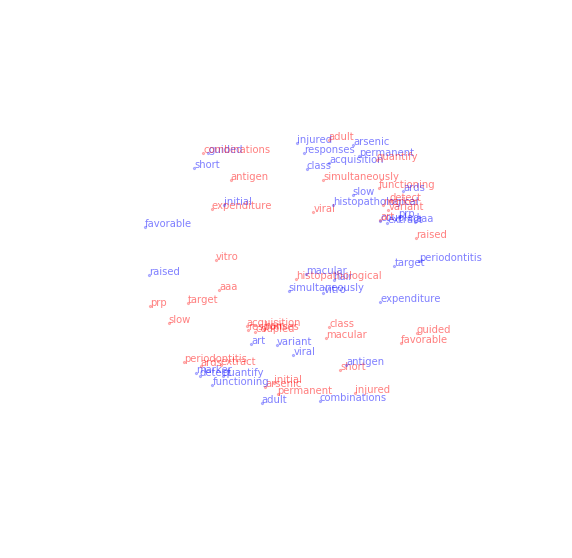

In [37]:
sample_idxs = [pair[1] for pair in least_similar_words[:35]]

#############################################################
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

u = np.linspace(0, np.pi, 20)
v = np.linspace(0, 2 * np.pi, 20)

eps = 0.000001
x = np.outer(np.sin(u), np.sin(v)) - eps
y = np.outer(np.sin(u), np.cos(v)) - eps
z = np.outer(np.cos(u), np.ones_like(v)) - eps

ax.plot_wireframe(x, y, z,
                color='k',
                linestyle='--',
                alpha=0.1)
dim1 = 0
dim2 = 1
dim3 = 2
for i,v in enumerate(sample_idxs):
    
    ax.scatter(U_c[v, dim1], U_c[v, dim2], U_c[v, dim3],
                color='r', marker=marker_,
                alpha=0.25)
    ax.text(U_c[v, dim1], U_c[v, dim2], U_c[v, dim3],
             s=shared_vocabulary[v],
             color='r',alpha=0.5)

    ax.scatter(V_c[v, dim1], V_c[v, dim2], V_c[v, dim3],
                color='b', marker=marker_,
                alpha=0.25)
    ax.text(V_c[v, dim1], V_c[v, dim2], V_c[v, dim3],
             s=shared_vocabulary[v],
             color='b',alpha=0.5)

ax.axis('off')


plt.savefig('figures_2/sphere distant words for worlds 1 2.png',
            transparent=True,
            bbox_inches='tight')
plt.savefig('figures_2/sphere distant words for worlds 1 2.pdf',
            transparent=True,
            bbox_inches='tight')

###############################################

#   plot the wireframe+points / points+text separately

marker_ = 'o'

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

u = np.linspace(0, np.pi, 20)
v = np.linspace(0, 2 * np.pi, 20)

eps = 0.000001
x = np.outer(np.sin(u), np.sin(v)) - eps
y = np.outer(np.sin(u), np.cos(v)) - eps
z = np.outer(np.cos(u), np.ones_like(v)) - eps

ax.plot_wireframe(x, y, z,
                color='k',
                linestyle='--',
                alpha=0.1)
dim1 = 0
dim2 = 1
dim3 = 2
for i,v in enumerate(sample_idxs):
    
    ax.scatter(U_c[v, dim1], U_c[v, dim2], U_c[v, dim3],
                color='r', marker=marker_,
                alpha=0.25)
    ax.scatter(V_c[v, dim1], V_c[v, dim2], V_c[v, dim3],
                color='b', marker=marker_,
                alpha=0.25)

ax.axis('off')


plt.savefig('figures_2/sphere distant words for worlds 1 2_points only.png',
            transparent=True,
            bbox_inches='tight')
plt.savefig('figures_2/sphere distant words for worlds 1 2_points only.pdf',
            transparent=True,
            bbox_inches='tight')

###############################################

marker_ = '.'
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

dim1 = 0
dim2 = 1
dim3 = 2
for i,v in enumerate(sample_idxs):

    ax.scatter(U_c[v, dim1], U_c[v, dim2], U_c[v, dim3],
                color='r', marker=marker_,
                alpha=0.25)
    ax.text(U_c[v, dim1], U_c[v, dim2], U_c[v, dim3],
             s=shared_vocabulary[v],
             color='r',alpha=0.5)

    ax.scatter(V_c[v, dim1], V_c[v, dim2], V_c[v, dim3],
                color='b', marker=marker_,
                alpha=0.25)
    ax.text(V_c[v, dim1], V_c[v, dim2], V_c[v, dim3],
             s=shared_vocabulary[v],
             color='b',alpha=0.5)
ax.axis('off')

plt.savefig('figures_2/sphere distant words for worlds 1 2_text only.png',
            transparent=True,
            bbox_inches='tight')
plt.savefig('figures_2/sphere distant words for worlds 1 2_text only.pdf',
            transparent=True,
            bbox_inches='tight')


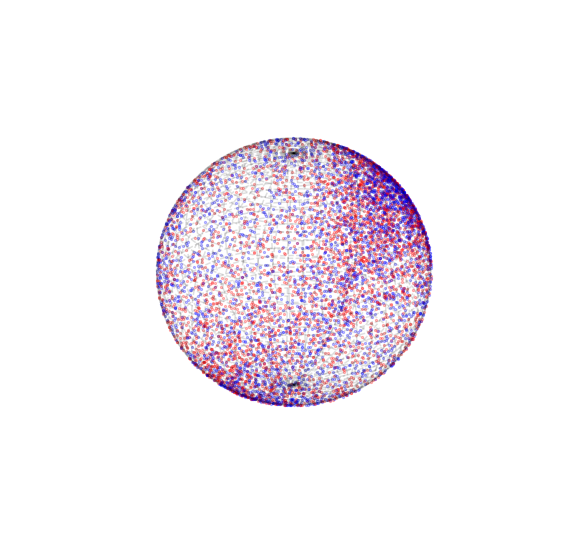

In [27]:
# sanity check:
'''
for i, v in enumerate(sample_idxs):    
    plt.figure()
    merged = np.vstack( (U_c[v,:], V_c[v,:]) )
    plt.imshow(merged, aspect='auto')
'''

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

# plot a spherical mesh
u_ = np.linspace(0, np.pi, 100)
v_ = np.linspace(0, 2 * np.pi, 100)

x_ = np.outer(np.sin(u_), np.sin(v_))
y_ = np.outer(np.sin(u_), np.cos(v_))
z_ = np.outer(np.cos(u_), np.ones_like(v_))

ax.plot_wireframe(x_, y_, z_,
                color='k',
                linestyle='--',
                alpha=0.125)

# plot the samples
dim1 = 0
dim2 = 1
dim3 = 2
marker_ = '.'
for i,(x,y,z) in enumerate(V_c):        
        
    ax.scatter(U_c[i, dim1], U_c[i, dim2], U_c[i, dim3],
                color='r', marker=marker_,
                alpha=0.25)

    ax.scatter(x,y,z,
                color='b', marker=marker_,
                alpha=0.25)
    
    #boundary = plt.Circle((0,0), 1, fc='none', ec='k',alpha=0.05)
    #plt.gca().add_artist(boundary)
    #plt.gca().axis('off')
    
ax.axis('off')   


plt.savefig('figures_2/sphere worlds 1 2.png',
            transparent=True,
            bbox_inches='tight')
plt.savefig('figures_2/sphere worlds 1 2.pdf',
            transparent=True,
            bbox_inches='tight')


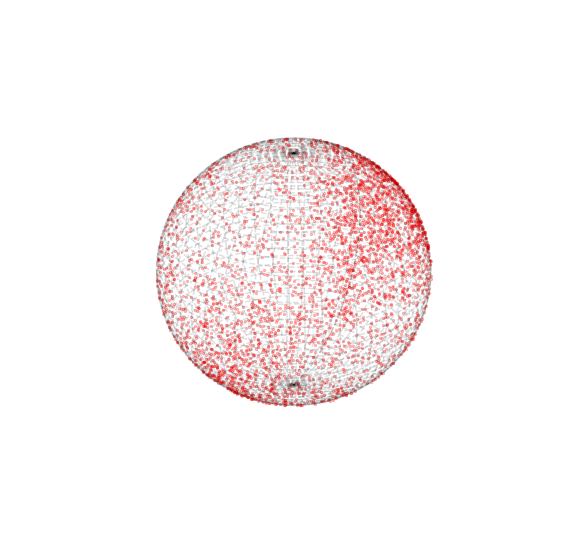

In [30]:
# sanity check:
'''
for i, v in enumerate(sample_idxs):    
    plt.figure()
    merged = np.vstack( (U_c[v,:], V_c[v,:]) )
    plt.imshow(merged, aspect='auto')
'''

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

# plot a spherical mesh
u_ = np.linspace(0, np.pi, 100)
v_ = np.linspace(0, 2 * np.pi, 100)

x_ = np.outer(np.sin(u_), np.sin(v_))
y_ = np.outer(np.sin(u_), np.cos(v_))
z_ = np.outer(np.cos(u_), np.ones_like(v_))

ax.plot_wireframe(x_, y_, z_,
                color='k',
                linestyle='--',
                alpha=0.125)

# plot the samples
dim1 = 0
dim2 = 1
dim3 = 2
marker_ = '.'
for i,(x,y,z) in enumerate(U_c):        

    ax.scatter(x,y,z,
                color='r', marker=marker_,
                alpha=0.25)
    
    #boundary = plt.Circle((0,0), 1, fc='none', ec='k',alpha=0.05)
    #plt.gca().add_artist(boundary)
    #plt.gca().axis('off')
    
ax.axis('off')   

plt.savefig('figures_2/sphere world 1.png',
            transparent=True,
            bbox_inches='tight')
plt.savefig('figures_2/sphere world 1.pdf',
            transparent=True,
            bbox_inches='tight')


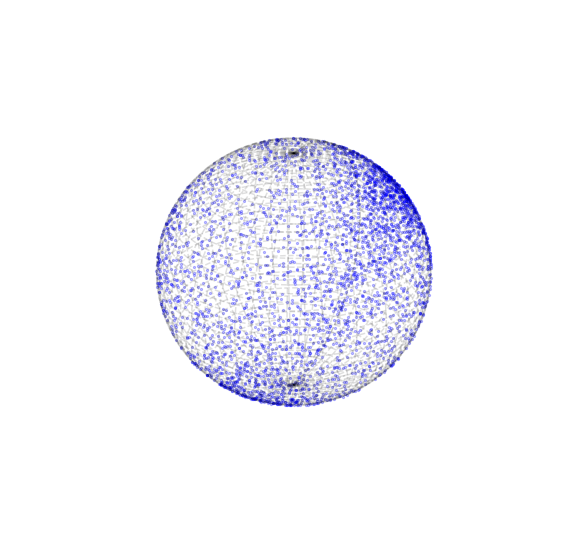

In [31]:
# sanity check:
'''
for i, v in enumerate(sample_idxs):    
    plt.figure()
    merged = np.vstack( (U_c[v,:], V_c[v,:]) )
    plt.imshow(merged, aspect='auto')
'''

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

# plot a spherical mesh
u_ = np.linspace(0, np.pi, 100)
v_ = np.linspace(0, 2 * np.pi, 100)

x_ = np.outer(np.sin(u_), np.sin(v_))
y_ = np.outer(np.sin(u_), np.cos(v_))
z_ = np.outer(np.cos(u_), np.ones_like(v_))

ax.plot_wireframe(x_, y_, z_,
                color='k',
                linestyle='--',
                alpha=0.125)

# plot the samples
dim1 = 0
dim2 = 1
dim3 = 2
marker_ = '.'
for i,(x,y,z) in enumerate(V_c):        
        
    ax.scatter(x,y,z,
                color='b', marker=marker_,
                alpha=0.25)
    
    #boundary = plt.Circle((0,0), 1, fc='none', ec='k',alpha=0.05)
    #plt.gca().add_artist(boundary)
    #plt.gca().axis('off')
    
ax.axis('off')   


plt.savefig('figures_2/sphere world 2.png',
            transparent=True,
            bbox_inches='tight')
plt.savefig('figures_2/sphere world 2.pdf',
            transparent=True,
            bbox_inches='tight')


### extend the trained CCA model to full vocabularies

In [41]:
# get full embeddings for each world

# U
model_idx = short_names[0]
U_vectors_all = np.zeros( (len(models[model_idx].wv.vocab), D) )

for i_word, word in enumerate(models[model_idx].wv.vocab):
    U_vectors_all[i_word,:] = models[model_idx].wv[word]
             
# V     
model_idx = short_names[1]
V_vectors_all = np.zeros( (len(models[model_idx].wv.vocab), D) )

for i_word, word in enumerate(models[model_idx].wv.vocab):
    V_vectors_all[i_word,:] = models[model_idx].wv[word]  
    

U_all, V_all = cca.transform(U_vectors_all, V_vectors_all)  

(5275, 3)


(-1.0999074798472743,
 1.0997329855537932,
 -1.099994983683128,
 1.0999811800082262)

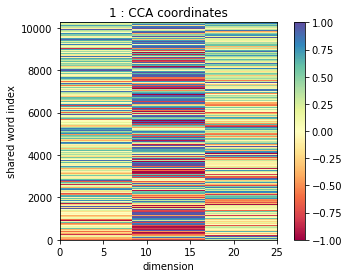

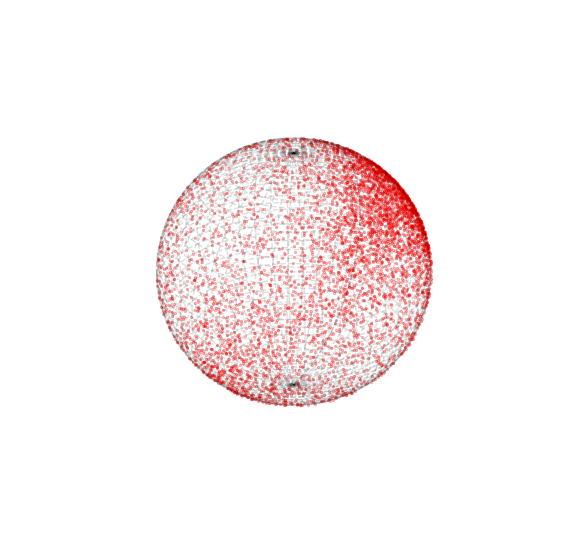

In [42]:

print(np.shape(U_all))

doNorm = True
if doNorm:
    for i_row, row in enumerate(U_all):
        U_all[i_row,:] = row / np.linalg.norm(row)

plt.figure()
plt.imshow(U_all,
           origin='lower',
           extent=[0,D,0,len(models[model_idx].wv.vocab)],
           aspect= D / len(models[model_idx].wv.vocab),
           vmin = -1,
           vmax = 1,
           cmap='Spectral')     
plt.colorbar()
plt.title('{} : CCA coordinates'.format(1))
plt.xlabel('dimension')
plt.ylabel('shared word index')

#plt.savefig('figures_2/w2v CCA coords {}.png'.format(1))
#plt.savefig('figures_2/w2v CCA coords {}.svg'.format(1))





fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

# plot a spherical mesh
u_ = np.linspace(0, np.pi, 100)
v_ = np.linspace(0, 2 * np.pi, 100)

x_ = np.outer(np.sin(u_), np.sin(v_))
y_ = np.outer(np.sin(u_), np.cos(v_))
z_ = np.outer(np.cos(u_), np.ones_like(v_))

ax.plot_wireframe(x_, y_, z_,
                color='k',
                linestyle='--',
                alpha=0.125)

# plot the samples
dim1 = 0
dim2 = 1
dim3 = 2
marker_ = '.'
for i,(x,y,z) in enumerate(U_all):        
        
    ax.scatter(x,y,z,
                color='r', marker=marker_,
                alpha=0.25)
    
    #boundary = plt.Circle((0,0), 1, fc='none', ec='k',alpha=0.05)
    #plt.gca().add_artist(boundary)
    #plt.gca().axis('off')
    
ax.axis('off')   




(10261, 3)


(-1.0997230983107518,
 1.0997230983107518,
 -1.0995436363385989,
 1.0998464021506595)

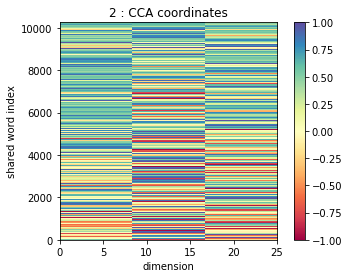

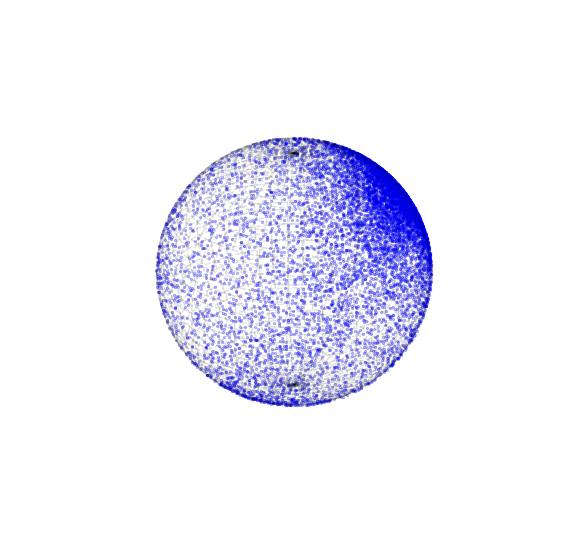

In [43]:
                                  
        
print(np.shape(V_all))

doNorm = True
if doNorm:
    for i_row, row in enumerate(V_all):
        V_all[i_row,:] = row / np.linalg.norm(row)

plt.figure()
plt.imshow(V_all,
           origin='lower',
           extent=[0,D,0,len(models[model_idx].wv.vocab)],
           aspect= D / len(models[model_idx].wv.vocab),
           vmin = -1,
           vmax = 1,
           cmap='Spectral')     
plt.colorbar()
plt.title('{} : CCA coordinates'.format(2))
plt.xlabel('dimension')
plt.ylabel('shared word index')


fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

# plot a spherical mesh
u_ = np.linspace(0, np.pi, 100)
v_ = np.linspace(0, 2 * np.pi, 100)

x_ = np.outer(np.sin(u_), np.sin(v_))
y_ = np.outer(np.sin(u_), np.cos(v_))
z_ = np.outer(np.cos(u_), np.ones_like(v_))

ax.plot_wireframe(x_, y_, z_,
                color='k',
                linestyle='--',
                alpha=0.125)

# plot the samples
dim1 = 0
dim2 = 1
dim3 = 2
marker_ = '.'
for i,(x,y,z) in enumerate(V_all):        
        
    ax.scatter(x,y,z,
                color='b', marker=marker_,
                alpha=0.25)
    
    #boundary = plt.Circle((0,0), 1, fc='none', ec='k',alpha=0.05)
    #plt.gca().add_artist(boundary)
    #plt.gca().axis('off')
    
ax.axis('off')   




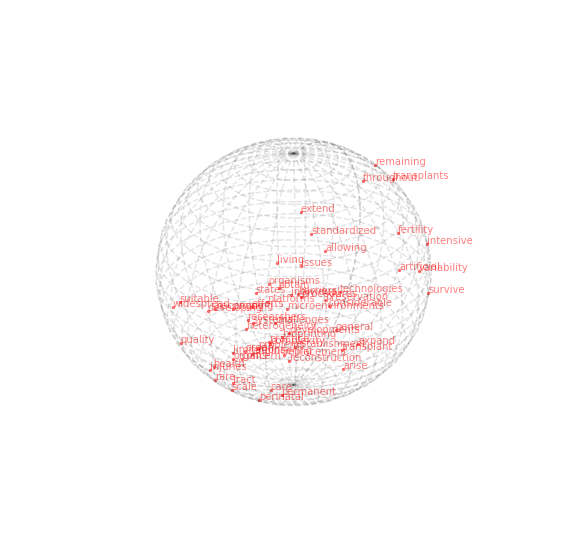

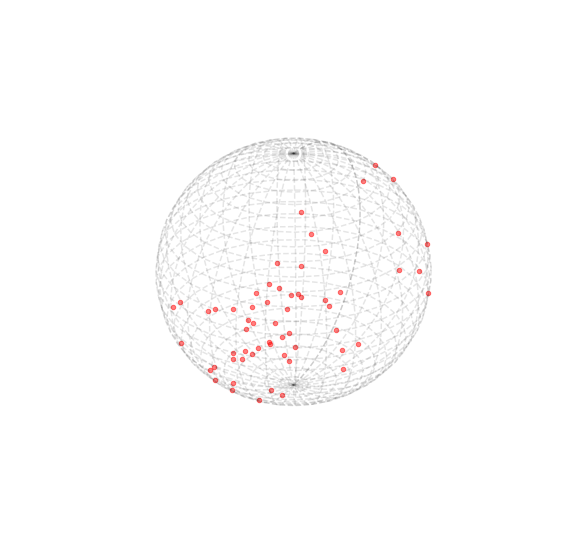

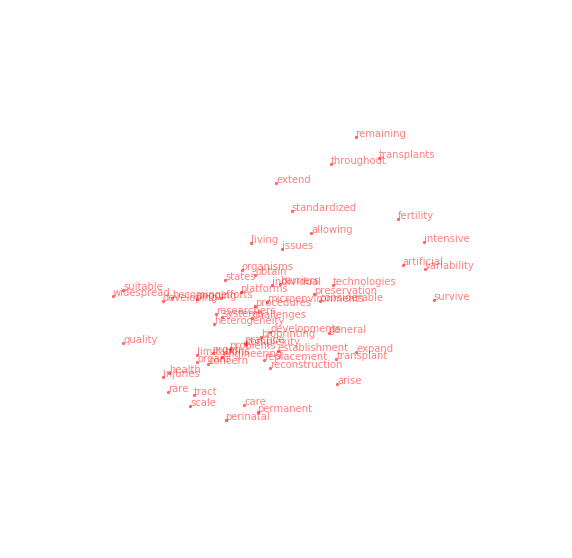

In [56]:
## plot the high centrality nodes

# copied by hand from explain_clusters.ipynb
cluster1_central = [3647, 4960, 4935, 2769, 2608, 4273, 2563, 3084, 1899, 3181, 1798, 2920, 3581, 1865, 2212, 
                    3083, 5200, 4276, 1872, 1200, 2356, 2553, 3679, 3844, 3661, 1503, 1203, 3810, 4141, 4089, 
                    4306, 2943, 3997, 4641, 4602, 3971, 3912, 2556, 201, 3198, 3476, 2155, 2808, 4978, 2501, 
                    4627, 2370, 3706, 2770, 4035, 3378, 3883, 1025, 3625, 3256, 1186, 5121, 2337, 3870, 4212]
                    #1030, 832, 1170, 1708, 3867, 1026, 4378, 4099, 4300, 1399, 1023, 1934, 1675, 4430, 3036, 319,
                    #2784, 4050, 3040]
clusterID = 0  # list index (this is cluster 1)
this_vocab = [w for w in models[short_names[clusterID]].wv.vocab]

######################################################################################


fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

# plot a spherical mesh
u_ = np.linspace(0, np.pi, 30)
v_ = np.linspace(0, 2 * np.pi, 30)

x_ = np.outer(np.sin(u_), np.sin(v_))
y_ = np.outer(np.sin(u_), np.cos(v_))
z_ = np.outer(np.cos(u_), np.ones_like(v_))

ax.plot_wireframe(x_, y_, z_,
                color='k',
                linestyle='--',
                alpha=0.1)

# plot the samples
dim1 = 0
dim2 = 1
dim3 = 2
marker_ = '.'
for i,(x,y,z) in enumerate(U_all):        
        
    if i in cluster1_central:
        ax.scatter(x,y,z,
                    color='r', marker=marker_,
                    alpha=0.5)
        ax.text(x,y,z,
                s=this_vocab[i],
                    color='r',
                    alpha=0.5)

ax.axis('off')   

plt.savefig('figures_2/globe eigcentral words cluster1.png',
            transparent=True,
            bbox_inches='tight')
plt.savefig('figures_2/globe eigcentral words cluster1.pdf',
            transparent=True,
            bbox_inches='tight')

#####################################################################################

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

# plot a spherical mesh
u_ = np.linspace(0, np.pi, 30)
v_ = np.linspace(0, 2 * np.pi, 30)

x_ = np.outer(np.sin(u_), np.sin(v_))
y_ = np.outer(np.sin(u_), np.cos(v_))
z_ = np.outer(np.cos(u_), np.ones_like(v_))

ax.plot_wireframe(x_, y_, z_,
                color='k',
                linestyle='--',
                alpha=0.1)

# plot the samples
dim1 = 0
dim2 = 1
dim3 = 2
marker_ = 'o'
for i,(x,y,z) in enumerate(U_all):        
        
    if i in cluster1_central:
        ax.scatter(x,y,z,
                    color='r', marker=marker_,
                    alpha=0.5)

ax.axis('off')   


plt.savefig('figures_2/globe eigcentral words cluster1_points only.png',
            transparent=True,
            bbox_inches='tight')
plt.savefig('figures_2/globe eigcentral words cluster1_points only.pdf',
            transparent=True,
            bbox_inches='tight')

#####################################################################################

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

# plot the samples
dim1 = 0
dim2 = 1
dim3 = 2
marker_ = '.'
for i,(x,y,z) in enumerate(U_all):        
        
    if i in cluster1_central:
        ax.scatter(x,y,z,
                    color='r', marker=marker_,
                    alpha=0.5)
        ax.text(x,y,z,
                s=this_vocab[i],
                    color='r',
                    alpha=0.5)

ax.axis('off')   

plt.savefig('figures_2/globe eigcentral words cluster1_text only.png',
            transparent=True,
            bbox_inches='tight')
plt.savefig('figures_2/globe eigcentral words cluster1_text only.pdf',
            transparent=True,
            bbox_inches='tight')

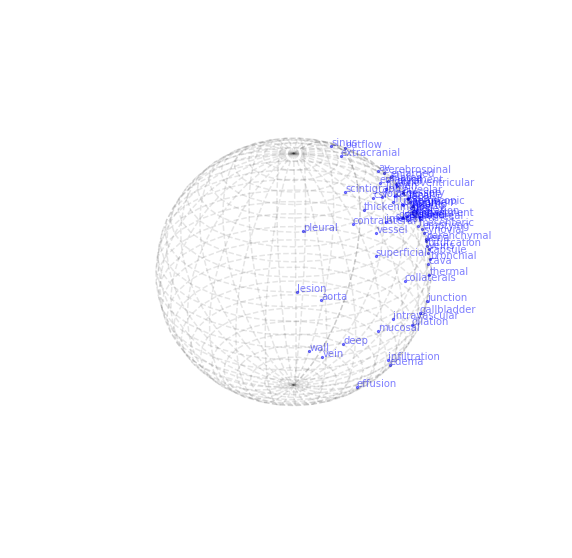

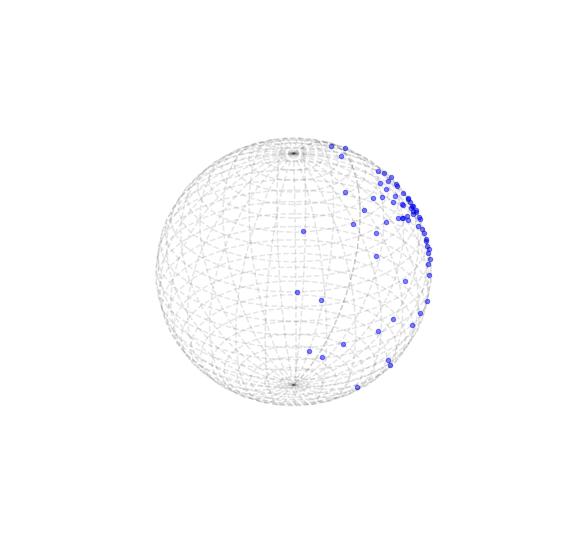

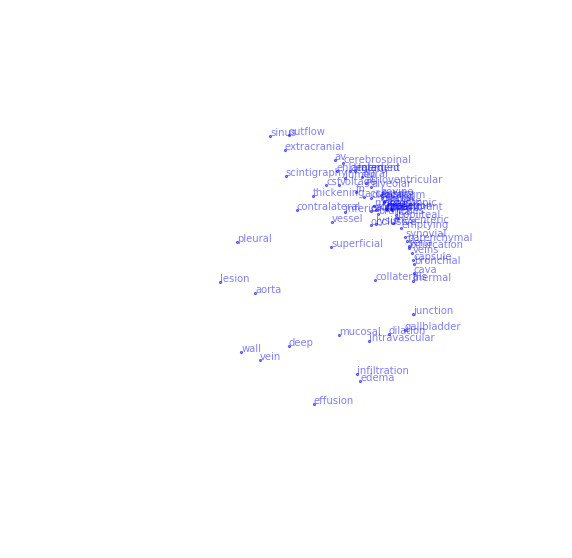

In [57]:
cluster2_central = [3638, 6428, 3316, 4172, 8704, 3318, 6722, 3317, 2741, 7830, 5047, 7835, 7893, 6174, 3312, 917, 6099, 2434, 5647,
                    9784, 7072, 8961, 2380, 2373, 8485, 7067, 6982, 7100, 4855,
                    5741, 3336, 9435, 9826, 3821, 8909, 3145, 3326, 9210, 5396, 2435, 7701, 8626, 9158, 4818, 6727, 2296, 6981, 3900,
                    2297, 3182, 7090, 9471, 9503, 8785, 3830, 3805, 9372, 6703, 6291, 3319, 8169, 9146, 6674, 2300, 902, 9409, 5404] 
                   # 1316, 8779, 3329, 948, 881, 7668, 9509, 2987, 9452, 4970, 10126, 2531, 6279, 3559, 7654, 7667, 9938, 967, 9283]
                   # 2742, 2539, 8855, 9125, 3023, 9559, 2428, 3608, 4824, 6707, 8149, 3399, 8041, 4976, 9374, 7549, 7775, 5356, 8872,
                   # 9294, 1327, 2528, 9925, 790, 3632, 993, 7069, 2426, 9181, 5400, 7035, 3763, 9701, 7273, 8989, 4932, 5089, 8338, 
                   # 6047, 8446, 8547, 8831, 8962, 3983, 2443, 9634, 7040, 9497, 4798, 3541, 6289, 4974, 4536, 952, 937, 5535, 7073,
                   # 4235, 5667, 3170, 2900, 8057, 4103, 8448, 4965, 9951, 3315]
clusterID = 1  # list index (this is cluster 2)
this_vocab = [w for w in models[short_names[clusterID]].wv.vocab]

######################################################################################

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

# plot a spherical mesh
u_ = np.linspace(0, np.pi, 30)
v_ = np.linspace(0, 2 * np.pi, 30)

x_ = np.outer(np.sin(u_), np.sin(v_))
y_ = np.outer(np.sin(u_), np.cos(v_))
z_ = np.outer(np.cos(u_), np.ones_like(v_))

ax.plot_wireframe(x_, y_, z_,
                color='k',
                linestyle='--',
                alpha=0.1)

# plot the samples
dim1 = 0
dim2 = 1
dim3 = 2
marker_ = '.'
for i,(x,y,z) in enumerate(V_all):    
    
    if i in cluster2_central:
        
        ax.scatter(x,y,z,
                    color='b', marker=marker_,
                    alpha=0.5)
        
        ax.text(x,y,z,
                s=this_vocab[i],
                    color='b',
                    alpha=0.5)

    
ax.axis('off')   

plt.savefig('figures_2/globe eigcentral words cluster2.png',
            transparent=True,
            bbox_inches='tight')
plt.savefig('figures_2/globe eigcentral words cluster2.pdf',
            transparent=True,
            bbox_inches='tight')

####################################################################3

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

# plot a spherical mesh
u_ = np.linspace(0, np.pi, 30)
v_ = np.linspace(0, 2 * np.pi, 30)

x_ = np.outer(np.sin(u_), np.sin(v_))
y_ = np.outer(np.sin(u_), np.cos(v_))
z_ = np.outer(np.cos(u_), np.ones_like(v_))

ax.plot_wireframe(x_, y_, z_,
                color='k',
                linestyle='--',
                alpha=0.1)

# plot the samples
dim1 = 0
dim2 = 1
dim3 = 2
marker_ = 'o'
for i,(x,y,z) in enumerate(V_all):    
    
    if i in cluster2_central:
        
        ax.scatter(x,y,z,
                    color='b', marker=marker_,
                    alpha=0.5)
    
ax.axis('off')   

plt.savefig('figures_2/globe eigcentral words cluster2_points only.png',
            transparent=True,
            bbox_inches='tight')
plt.savefig('figures_2/globe eigcentral words cluster2_points only.pdf',
            transparent=True,
            bbox_inches='tight')



######################################################################

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

# plot the samples
dim1 = 0
dim2 = 1
dim3 = 2
marker_ = '.'
for i,(x,y,z) in enumerate(V_all):    
    
    if i in cluster2_central:
        
        ax.scatter(x,y,z,
                    color='b', marker=marker_,
                    alpha=0.5)
        
        ax.text(x,y,z,
                s=this_vocab[i],
                    color='b',
                    alpha=0.5)

    
ax.axis('off')   

plt.savefig('figures_2/globe eigcentral words cluster2_text only.png',
            transparent=True,
            bbox_inches='tight')
plt.savefig('figures_2/globe eigcentral words cluster2_text only.pdf',
            transparent=True,
            bbox_inches='tight')
